# In this notebook: 
   * Choose three summarization models
   * Calculate the most popular metrics
   * Choose one from all models to use it in my project

# Import all libraries and dependencies

In [1]:
!pip install bert_score

   ---------------------------------------- 0.0/61.1 kB ? eta -:--:--
   ------ --------------------------------- 10.2/61.1 kB ? eta -:--:--
   -------------------- ------------------- 30.7/61.1 kB 640.0 kB/s eta 0:00:01
   -------------------------- ------------- 41.0/61.1 kB 279.3 kB/s eta 0:00:01
   ---------------------------------------- 61.1/61.1 kB 361.0 kB/s eta 0:00:00


In [1]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, AutoModel, BartForCausalLM, pipeline
import numpy as np
from rouge import Rouge
import nltk
from nltk.translate.bleu_score import sentence_bleu
from bert_score import score

C:\Users\User\.conda\envs\coding\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Let's load all models

# There are..
   * Ainiz\Bart Base CNN
   * Kasperchux\BartBaseSummarization (It's my model)
   * Falconsai/text-summarization

In [2]:
tokenizer_1 = AutoTokenizer.from_pretrained("ainize/bart-base-cnn")
model_1 = BartForCausalLM.from_pretrained("ainize/bart-base-cnn")

In [3]:
tokenizer_3 = AutoTokenizer.from_pretrained("Falconsai/text_summarization")
model_3 = AutoModelForSeq2SeqLM.from_pretrained("Falconsai/text_summarization")

In [4]:
tokenizer_2 = AutoTokenizer.from_pretrained("kasperchux/Bart-Base-Summarization")
model_2 = AutoModelForSeq2SeqLM.from_pretrained("kasperchux/Bart-Base-Summarization")

# Essential function to summarize the text
 We will use it while testing model

This code taken from Bart-Base page on Hugging Face.

In [51]:
def summarize_bart_base_func(model, tokenizer, input_text):
    input_ids = tokenizer.encode(input_text, return_tensors="pt")

    # Generate Summary Text Ids
    summary_text_ids = model.generate(
        input_ids=input_ids,
        bos_token_id=model.config.bos_token_id,
        eos_token_id=model.config.eos_token_id,
        length_penalty=2.0,
        max_length=1000,
        min_length=56,
        num_beams=4,
    )
    
    # Decoding Text
    return tokenizer.decode(summary_text_ids[0], skip_special_tokens=True)

This code taken from model_interface/Summarizer.py

In [6]:
def summarize_bart_base_kasperchuk_func(model, tokenizer, text: str) -> str:
    input_ids = tokenizer.encode(text, return_tensors='pt') # Encode it
    output = model.generate(input_ids)  # Get summarized text 
    output_text = tokenizer.decode(output[0], skip_special_tokens=True) # Decode it.
    return output_text 

In [22]:
def summarize_falcon_func(model, tokenizer, text) -> str:
    summarizer = pipeline("summarization", model=model, tokenizer=tokenizer)
    summ = summarizer(text, max_length=800, min_length=0, do_sample=False)
    return summ[0]["summary_text"]

# Download dataset to calculate metrics
 it will be "abisee/cnn_dailymail"

In [8]:
test_dataset = load_dataset("abisee/cnn_dailymail", "3.0.0", split="test")

In [73]:
test_sample = test_dataset.select(range(50)) # Select 20 rows from dataset 

In [10]:
test_sample[0]

{'article': '(CNN)The Palestinian Authority officially became the 123rd member of the International Criminal Court on Wednesday, a step that gives the court jurisdiction over alleged crimes in Palestinian territories. The formal accession was marked with a ceremony at The Hague, in the Netherlands, where the court is based. The Palestinians signed the ICC\'s founding Rome Statute in January, when they also accepted its jurisdiction over alleged crimes committed "in the occupied Palestinian territory, including East Jerusalem, since June 13, 2014." Later that month, the ICC opened a preliminary examination into the situation in Palestinian territories, paving the way for possible war crimes investigations against Israelis. As members of the court, Palestinians may be subject to counter-charges as well. Israel and the United States, neither of which is an ICC member, opposed the Palestinians\' efforts to join the body. But Palestinian Foreign Minister Riad al-Malki, speaking at Wednesday

In [74]:
test_sample.remove_columns(["id"])

Dataset({
    features: ['article', 'highlights'],
    num_rows: 50
})

In [75]:
references = [ex["highlights"] for ex in test_sample] # Get only summary

In [76]:
references

['Membership gives the ICC jurisdiction over alleged crimes committed in Palestinian territories since last June .\nIsrael and the United States opposed the move, which could open the door to war crimes investigations against Israelis .',
 'Theia, a bully breed mix, was apparently hit by a car, whacked with a hammer and buried in a field .\n"She\'s a true miracle dog and she deserves a good life," says Sara Mellado, who is looking for a home for Theia .',
 'Mohammad Javad Zarif has spent more time with John Kerry than any other foreign minister .\nHe once participated in a takeover of the Iranian Consulate in San Francisco .\nThe Iranian foreign minister tweets in English .',
 '17 Americans were exposed to the Ebola virus while in Sierra Leone in March .\nAnother person was diagnosed with the disease and taken to hospital in Maryland .\nNational Institutes of Health says the patient is in fair condition after weeks of treatment .',
 'Student is no longer on Duke University campus and w

# And now, let's write function 'calculate_metrics'

In [37]:
def calculate_metrics(model, tokenizer, func_summarize) -> list:
    rouge_list = []
    bleu_list = []
    precision_list = []
    recall_list = []
    f1_score_list = []
    
    for index, example in enumerate(test_sample):
        # Take example from sample
        source = example["article"]
        summary = func_summarize(model, tokenizer, source)
        
        # Calculate BLEU-metric
        tokenized_summary = nltk.word_tokenize(summary, language="english")
        tokenized_reference = nltk.word_tokenize(references[index], language="english")
        cur_bleu = sentence_bleu([tokenized_reference], tokenized_summary)
        bleu_list.append(cur_bleu)
        
        # Calculate Bert-Score
        precision, recall, f1 = score(
        [summary], [references[index]], lang='en', verbose=False)
        precision = float(precision)
        recall = float(recall)
        f1 = float(f1)
        precision_list.append(precision)
        recall_list.append(recall)
        f1_score_list.append(f1)

        # Return all metrics
    return [bleu_list, precision_list, recall_list, f1_score_list]
            

## Metrics

### 1. ROUGE (Recall-Oriented Understudy for Gisting Evaluation)

**Formula:**

$$
\text{ROUGE-N} = \frac{\sum_{} \text{Count of N-grams in S} \cap \text{Count of N-grams in Candidate Summary}}{\text{Count of N-grams in Summary}}
$$

**About it:**

* ROUGE-N measures the concordance of N-grams (sequences of N words) between the abstract and the source text.
* The higher the ROUGE-N value, the more N-grams match, indicating a better quality abstract.

### 2. BLEU (Bilingual Evaluation Understudy)

**Formula:**

$$
\text{BLEU} = \text{BP} \times \exp\left(\sum_{n=1}^N w_n \log p_n \right)
$$

**Where:**

* BP - penalty for too short abstracts.
* $p_n$ - accuracy of N-grams.
* $w_n$ - weights for different N-grams.

**About it:**

* BLEU measures the accuracy and smoothness of the abstract compared to the source text.
* The higher the BLEU value, the more accurate and smooth the abstract.

### 3. BERTScore

**Formula:**

$$
\text{BERTScore} = \frac{S(c,r) + S(r,c)}{2}
$$

**Where:**

* $S(c,r)$ - evaluation of the similarity of the abstract ($c$) with the source text ($r$) according to the BERT model.
* $S(r,c)$ - evaluation of the similarity of the source text ($r$) with the abstract ($c$) according to the BERT model.

**About it:**

* BERTScore uses the BERT model to evaluate the semantic similarity between the abstract and the source text.
* The higher the BERTScore value, the greater the semantic similarity, indicating a better quality abstract.

# Let's calculate all metrics

In [52]:
metrics_bart_base = calculate_metrics(model_1, tokenizer_1, summarize_bart_base_func)
print("Bart-Base's already calculated!")

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['ro

Bart-Base's already calculated!


In [77]:
metrics_kasperchux_bart_base = calculate_metrics(model_2, tokenizer_2, summarize_bart_base_kasperchuk_func)
print("Kasperchux/Bart-Base's already calculated!")

C:\Users\User\.conda\envs\coding\Lib\site-packages\transformers\generation\utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
C:\Users\User\.conda\envs\coding\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\User\.conda\envs\coding\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\User\.

IndexError: index out of range in self

In [54]:
metrics_falconai_ts = calculate_metrics(model_3, tokenizer_3, summarize_falcon_func)
print("FalconAI's metrics already calculated")

Your max_length is set to 800, but your input_length is only 789. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=394)
Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Your max_length is set to 800, but your input_length is only 581. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=290)
C:\Users\User\.conda\envs\coding\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently

FalconAI's metrics already calculated


In [61]:
def preprocess_metrics_for_presentation(metrics):
    bleu = metrics[0]
    precision = metrics[1]
    recall = metrics[2]
    f1 = metrics[3]
    
    avg_precision = np.mean(precision)
    avg_recall = np.mean(recall)
    avg_f1 = np.mean(f1)
    avg_bleu = np.mean(bleu)
    return avg_bleu, avg_precision, avg_recall, avg_f1

In [33]:
import pandas as pd

In [70]:
import seaborn as sns

In [65]:
bart_base_bleu, bart_base_precision, bart_base_recall, bart_base_f1_score = preprocess_metrics_for_presentation(metrics_bart_base)

In [63]:
kbart_base_bleu, kbart_base_precision, kbart_base_recall, kbart_base_f1_score = preprocess_metrics_for_presentation(metrics_kasperchux_bart_base) 

In [66]:
falcon_base_bleu, falcon_base_precision, falcon_base_recall, falcon_base_f1_score = preprocess_metrics_for_presentation(metrics_falconai_ts)

In [67]:
df = pd.DataFrame(
    {"Model": ["Bart-Base", "Kasperchux", "FalconAI"],
     "BLEU-Score": [bart_base_bleu, kbart_base_bleu, falcon_base_bleu],
     "Precision": [bart_base_precision, kbart_base_precision, falcon_base_precision],
     "Recall": [bart_base_recall, kbart_base_recall, falcon_base_recall],
     "F1-Score": [bart_base_f1_score, kbart_base_f1_score, falcon_base_f1_score],
     }
)

<Axes: xlabel='Model', ylabel='BLEU-Score'>

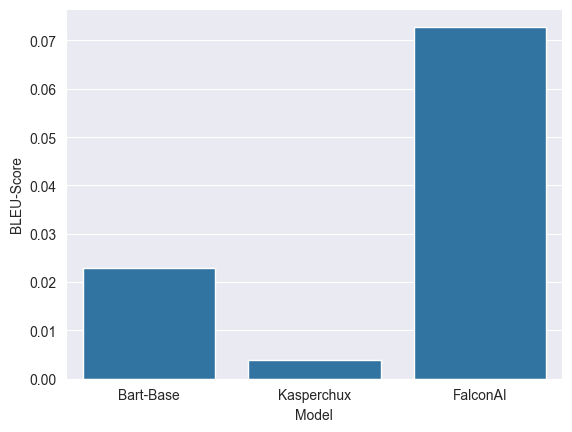

In [78]:
sns.barplot(x="Model", y="BLEU-Score", data=df)

<Axes: xlabel='Model', ylabel='F1-Score'>

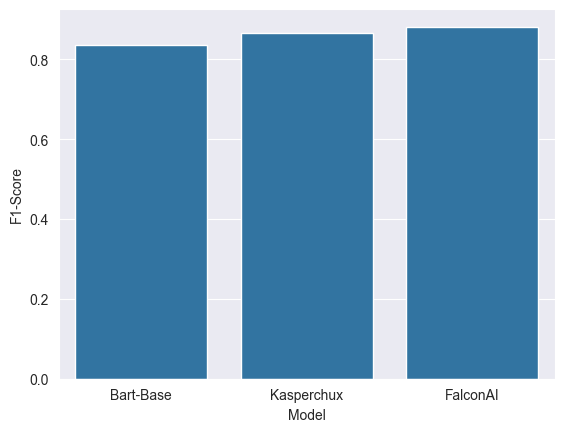

In [72]:
sns.barplot(x="Model", y="F1-Score", data=df)

# Let's come to conclusion..
As we can see, FalconAI's model show's the best, it has the biggest BLEU and F1-Score. So i will use it in this project as summarizer.
Bart-Base model also shows good result, but not so good as FalconAI. The third 'Kasperchux\bart-base-summarization, my model shows
the worth results in BLEU-metric. But it takes second place in F1-score. Bad results are in cause of very little num of training epochs (it's 1), and lack of computing units' 